In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pybamm
import pickle
import os
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [3]:
# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

In [4]:
discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

In [5]:
temp_list = list(discharge_data.keys())

In [6]:
# Here I am not going to work with changing the initial conditions the gradient descent
# so this is taking the ICs for granted 
Ms = 32
n4 = 4
F = 9.649e4
S8_initial = 2.6730
ns8 = 8
S4_initial = 0.0128
ns4 = 4
cth = ((3 * n4 * F * S8_initial / (ns8 * Ms)) + (n4 * F * S4_initial / (ns4 * Ms))) / 3600

# define the initial values in grams of various species
S8_initial_g = 2.6730
S4_initial_g = 0.0128
S2_initial_g = 4.3321e-6
S1_initial_g = 1.6321e-6
Sp_initial_g = 2.7e-06

# the total active material mass
m_s = S8_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.3

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

In [37]:
def hua_2019_alg_discharge_function_ks(inputs):
    
    fitted_params, temp = inputs
    
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    EL0, EH0, nu = fitted_params
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = discharge_initial_data
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        "Shuttle rate coefficient during discharge [s-1]": discharge_shuttle_rate,
        'S saturation mass [g]': saturation_mass,
        'Precipitation rate [s-1]': precipitation_rate,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": 298,
        'Active reaction area per cell [m2]': active_surface_area,
        'Cell heat transfer coefficient [W.K-1]': heat_transfer_coefficient,
        'Standard Potential L [V]': EL0,
        'Standard Potential H [V]': EH0,
        'Electrolyte volume per cell [L]': nu
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying number of time steps %f" %10**j)
        print("parameters are {}".format(fitted_params))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = [t, Ah, V, S8, S4, S2, S1, Sp, Tc]
            return data
            
            break
        except:
            pass


In [38]:
def hua_2019_alg_charge_function(inputs):
    
    fitted_params, temp = inputs
    
    current = -0.0211 # .1C charge
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    EL0, EH0, nu = fitted_params
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = charge_initial_data
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 0.00002,
        "Shuttle rate coefficient during discharge [s-1]": discharge_shuttle_rate,
        'S saturation mass [g]': saturation_mass,
        'Precipitation rate [s-1]': precipitation_rate,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": 298,
        'Active reaction area per cell [m2]': active_surface_area,
        'Cell heat transfer coefficient [W.K-1]': heat_transfer_coefficient,
        'Standard Potential L [V]': EL0,
        'Standard Potential H [V]': EH0,
        'Electrolyte volume per cell [L]': nu
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying time %f" %10**j)
        print("parameters are {}".format(fitted_params))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = [t, Ah, V, S8, S4, S2, S1, Sp, Tc]
            return data
            
            break
        except:
            pass


In [39]:
# here we are going to run the cell a few times, even with unfit parameters,
# to get a more reasonable initial condition. 

In [44]:
# set inititial guessed for the parameters we will fit
active_surface_area = 0.960
discharge_shuttle_rate = 0.00#02
saturation_mass = 0.0001
precipitation_rate = 100
heat_transfer_coefficient = .2

EH0 = 2.35
EL0 = 2.18
nu = 0.00114

fitted_params = np.array([EL0, EH0, nu])
temp = 30 + 272
inputs = fitted_params, temp

# Discharge 1
base_sim_data = hua_2019_alg_discharge_function_ks(inputs)

# Get IC for Charge 1
charge_initial_data = []
for sub_data in base_sim_data[2:-1]:
    charge_initial_data.append(sub_data[-2])
    
# Charge 1
base_sim_data = hua_2019_alg_charge_function(inputs)

# Get IC for Discharge 2
discharge_initial_data = []
for sub_data in base_sim_data[2:-1]:
    discharge_initial_data.append(sub_data[-2])
    
# Discharge 2
base_sim_data = hua_2019_alg_discharge_function_ks(inputs)

# Get IC for Charge 1
charge_initial_data = []
for sub_data in base_sim_data[2:-1]:
    charge_initial_data.append(sub_data[-2])
    
# Charge 2
base_sim_data = hua_2019_alg_charge_function(inputs)

# Get IC for Discharge 2
discharge_initial_data = []
for sub_data in base_sim_data[2:-1]:
    discharge_initial_data.append(sub_data[-2])
    
# Discharge 3
base_sim_data = hua_2019_alg_discharge_function_ks(inputs)

# Get IC for fitting Charge
charge_initial_data = []
for sub_data in base_sim_data[2:-1]:
    charge_initial_data.append(sub_data[-2])


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.18e+00 2.35e+00 1.14e-03]


At t = 15.5258 and h = 1.68823e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.309109 and h = 2.39159e-08, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: 

trying number of time steps 10000.000000
parameters are [2.18e+00 2.35e+00 1.14e-03]
Starting temperature 302.000000
trying time 1000.000000
parameters are [2.18e+00 2.35e+00 1.14e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.18e+00 2.35e+00 1.14e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.18e+00 2.35e+00 1.14e-03]
Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.18e+00 2.35e+00 1.14e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are [2.18e+00 2.35e+00 1.14e-03]


In [45]:
print(charge_initial_data)

[2.210115372605082, 1.1533246340333965e-16, 0.0001353028196586773, 0.08393234858943203, 0.00010190332991099184, 0.0838304452595263]


In [48]:
# Here we will perform the charge fitting
def quick_norm(gradient):
    return sum(gradient*gradient)

simulations_at_each_step = [base_sim_data]
parameters_at_each_step = [fitted_params]
gradient = np.array([1,1])
while quick_norm(gradient) > 1e-7:

    # get new parameters
    params = parameters_at_each_step[-1]

    #### down sample previous simulation for gradient calculation ###
    # get simulation data
    t, Ah, V, S8, S4, S2, S1, Sp, Tc = simulations_at_each_step[-1]

    # get experimental data capacity
    exp_capacity = charge_data['30']['capacity']

    # check if simulation stops short of experimental capacity and adjust
    if Ah[-1] < exp_capacity[-1]:
        exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]

    exp_voltage = charge_data['30']['internal voltage'][0:len(exp_capacity)]

    # down sample simulated voltage for comparison with experimental 
    down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)

    ###########################################################

    # create steps for each parameter to fit
    individually_stepped_params = []
    epsilon = 0.0001
    for i in range(0,len(params)):
        step_factor = np.ones(len(params))
        step_factor[i] = 1+epsilon
        individually_stepped_params.append(params*step_factor)
    print('\n\n\n')
    print(individually_stepped_params)
    print('\n\n\n')
    # run new simulations with individually stepped parameters
    individually_stepped_sims = []
    for i in individually_stepped_params:
        inputs = i, temp
        temp_sim = hua_2019_alg_charge_function(inputs)
        individually_stepped_sims.append(temp_sim)

    # downsample each sim to be able to subtract from base_sim for numerical derivative
    gradient = np.array([])
    for sims in individually_stepped_sims:
        # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes

        # down sample simulated voltage for comparison with experimental 
        temp_sim_V = np.interp(exp_capacity, sims[1], sims[2])
        voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon 
        gradient = np.append(gradient, sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage))

    print('\n\n\n')
    print(gradient)
    print('\n\n\n')
    lam = 0.0001/quick_norm(gradient)
    new_params = params - lam*(gradient + quick_norm(gradient)*np.random.rand(len(params)))
    
    # record new parameters 
    parameters_at_each_step.append(new_params)
    
    # obtain new simulation based on these new parameters
    inputs = new_params, temp
    new_sim = hua_2019_alg_charge_function(inputs)
    
    # record new simulation
    simulations_at_each_step.append(new_sim)
    print('\n\n\n gradient norm is {} \n\n\n'.format(quick_norm(gradient)))
    
    if len(simulations_at_each_step) > 50:
        break





[array([2.180218e+00, 2.350000e+00, 1.140000e-03]), array([2.180000e+00, 2.350235e+00, 1.140000e-03]), array([2.180000e+00, 2.350000e+00, 1.140114e-03])]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.180218e+00 2.350000e+00 1.140000e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.180000e+00 2.350235e+00 1.140000e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.180000e+00 2.350000e+00 1.140114e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





[-177.44760251 -177.87260461 -177.71983158]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17990724e+00 2.34995719e+00 1.07745870e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 94710.6536444121 







[array([2.18012523e+00, 2.34995719e+00, 1.07745870e-03]), array([2.17990724e+00, 2.35019218e+00, 1.07745870e-03]), array([2.17990724e+00, 2.34995719e+00, 1.07756644e-03])]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.18012523e+00 2.34995719e+00 1.07745870e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17990724e+00 2.35019218e+00 1.07745870e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17990724e+00 2.34995719e+00 1.07756644e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





[ 0.14218343 -0.02556347  0.00081144]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17914804e+00 2.35007761e+00 1.05252264e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.020870277961861278 







[array([2.17936596e+00, 2.35007761e+00, 1.05252264e-03]), array([2.17914804e+00, 2.35031261e+00, 1.05252264e-03]), array([2.17914804e+00, 2.35007761e+00, 1.05262790e-03])]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17936596e+00 2.35007761e+00 1.05252264e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17914804e+00 2.35031261e+00 1.05252264e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17914804e+00 2.35007761e+00 1.05262790e-03]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





[ 0.13898469 -0.02560339  0.00079104]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17840136e+00 2.35015315e+00 9.85951826e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.269144 and 




 gradient norm is 0.019972902463847992 







[array([2.17861920e+00, 2.35015315e+00, 9.85951826e-04]), array([2.17840136e+00, 2.35038816e+00, 9.85951826e-04]), array([2.17840136e+00, 2.35015315e+00, 9.86050421e-04])]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17861920e+00 2.35015315e+00 9.85951826e-04]
trying time 10000.000000
parameters are [2.17861920e+00 2.35015315e+00 9.85951826e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17840136e+00 2.35038816e+00 9.85951826e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17840136e+00 2.35015315e+00 9.86050421e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.269144 and 





[ 0.13403172 -0.02733616  0.00075759]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17766864e+00 2.35027849e+00 9.39936256e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.018712342518922807 







[array([2.17788641e+00, 2.35027849e+00, 9.39936256e-04]), array([2.17766864e+00, 2.35051352e+00, 9.39936256e-04]), array([2.17766864e+00, 2.35027849e+00, 9.40030250e-04])]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17788641e+00 2.35027849e+00 9.39936256e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17766864e+00 2.35051352e+00 9.39936256e-04]
trying time 10000.000000
parameters are [2.17766864e+00 2.35051352e+00 9.39936256e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17766864e+00 2.35027849e+00 9.40030250e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





[ 0.13021449 -0.02662053  0.00073096]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17690583e+00 2.35036591e+00 8.90168262e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.01766499981684131 







[array([2.17712352e+00, 2.35036591e+00, 8.90168262e-04]), array([2.17690583e+00, 2.35060095e+00, 8.90168262e-04]), array([2.17690583e+00, 2.35036591e+00, 8.90257279e-04])]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17712352e+00 2.35036591e+00 8.90168262e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17690583e+00 2.35060095e+00 8.90168262e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17690583e+00 2.35036591e+00 8.90257279e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





[ 0.12581932 -0.02708026  0.00070129]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17607026e+00 2.35045842e+00 8.36123048e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.01656433376128092 







[array([2.17628787e+00, 2.35045842e+00, 8.36123048e-04]), array([2.17607026e+00, 2.35069346e+00, 8.36123048e-04]), array([2.17607026e+00, 2.35045842e+00, 8.36206661e-04])]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17628787e+00 2.35045842e+00 8.36123048e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17607026e+00 2.35069346e+00 8.36123048e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17607026e+00 2.35045842e+00 8.36206661e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





[ 0.12087161 -0.02759539  0.00066801]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17523887e+00 2.35060469e+00 7.91020115e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.01537189716384978 







[array([2.17545640e+00, 2.35060469e+00, 7.91020115e-04]), array([2.17523887e+00, 2.35083975e+00, 7.91020115e-04]), array([2.17523887e+00, 2.35060469e+00, 7.91099218e-04])]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17545640e+00 2.35060469e+00 7.91020115e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17523887e+00 2.35083975e+00 7.91020115e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17523887e+00 2.35060469e+00 7.91099218e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





[ 0.11619253 -0.02901911  0.00063728]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17441316e+00 2.35080554e+00 7.76508281e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.014343218742199923 







[array([2.17463061e+00, 2.35080554e+00, 7.76508281e-04]), array([2.17441316e+00, 2.35104062e+00, 7.76508281e-04]), array([2.17441316e+00, 2.35080554e+00, 7.76585932e-04])]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17463061e+00 2.35080554e+00 7.76508281e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17441316e+00 2.35104062e+00 7.76508281e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17441316e+00 2.35080554e+00 7.76585932e-04]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c





[ 0.11313455 -0.02793587  0.00061834]




Starting temperature 302.000000
trying time 1000.000000
parameters are [2.17350437e+00 2.35098134e+00 7.04928608e-04]
trying time 10000.000000
parameters are [2.17350437e+00 2.35098134e+00 7.04928608e-04]
trying time 100000.000000
parameters are [2.17350437e+00 2.35098134e+00 7.04928608e-04]
trying time 1000000.000000
parameters are [2.17350437e+00 2.35098134e+00 7.04928608e-04]



 gradient norm is 0.013580222131385607 





psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

TypeError: cannot unpack non-iterable NoneType object

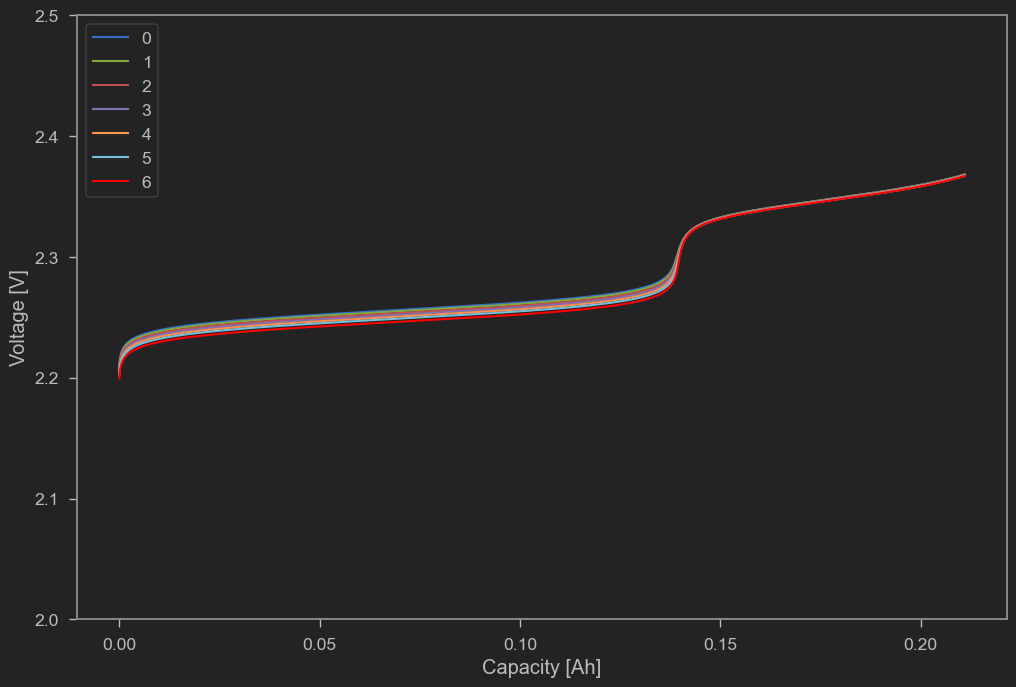

In [49]:
for simulations in simulations_at_each_step[1:-3]:
    plt.plot(simulations[1],simulations[2])
plt.plot(simulations_at_each_step[-2][1],simulations_at_each_step[-2][2],color='red')
plt.legend(np.arange(len(simulations_at_each_step)))
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.ylim(2,2.5)
notify

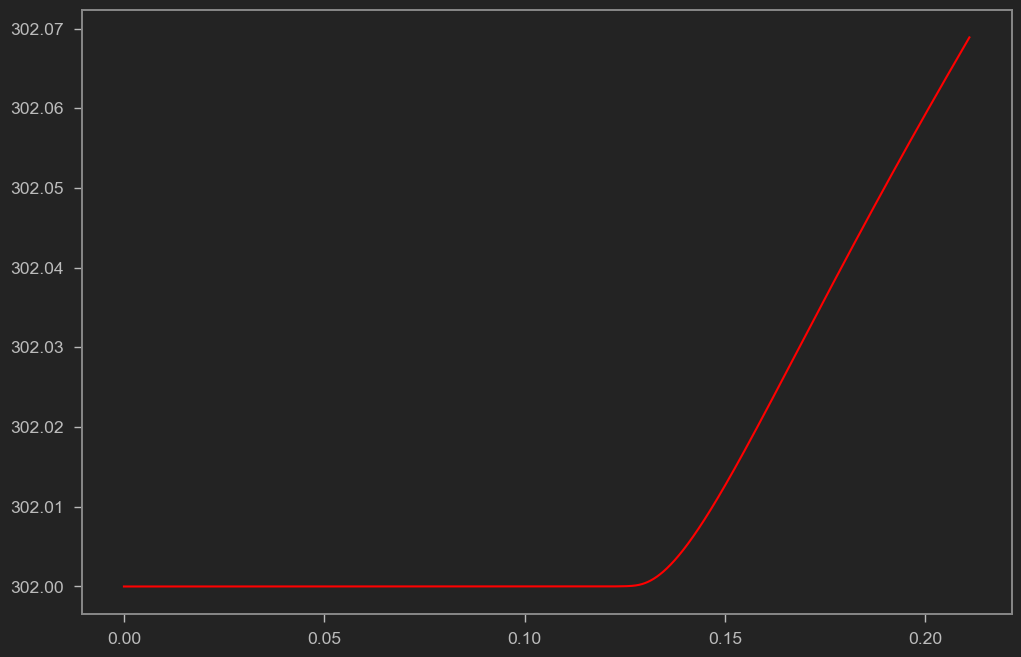

In [31]:
plt.plot(simulations_at_each_step[-2][1],simulations_at_each_step[-2][-1],color='red')

In [29]:
params

array([2.16996757, 2.34846454, 0.01032697])

In [30]:
gradient

array([0.19975641])

In [19]:
params

array([2.16864104, 2.34814826])

In [16]:
inputs = params, temp

In [17]:
discharge_initial_data = []
for sub_data in simulations_at_each_step[-3][2:-1]:
    discharge_initial_data.append(sub_data[-2])
    
# Discharge 2
base_sim_data = hua_2019_alg_discharge_function_ks(inputs)

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.16864104 2.34814826]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

(2.0, 2.5)

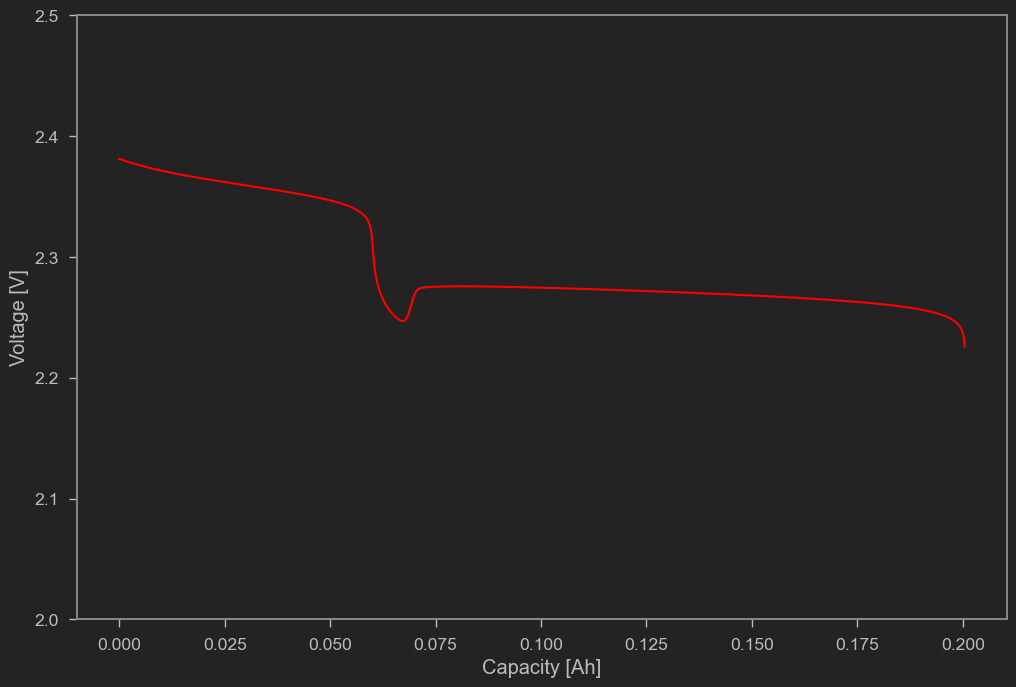

In [18]:
plt.plot(base_sim_data[1],base_sim_data[2],color='red')
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.ylim(2,2.5)

In [408]:
# set inititial guessed for the parameters we will fit
active_surface_area = 0.960
discharge_shuttle_rate = 0.00#02
saturation_mass = 0.0001
precipitation_rate = 100
heat_transfer_coefficient = .2

EH0 = 2.35
EL0 = 2.18

fitted_params = np.array([EL0, EH0])

In [409]:
temp = 30 + 272
inputs = fitted_params, temp

In [410]:
# here we are going to try to make gradient descent work without functions

# get the simulation 
base_sim_data = hua_2019_alg_discharge_function_ks(inputs)
notify

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.18 2.35]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

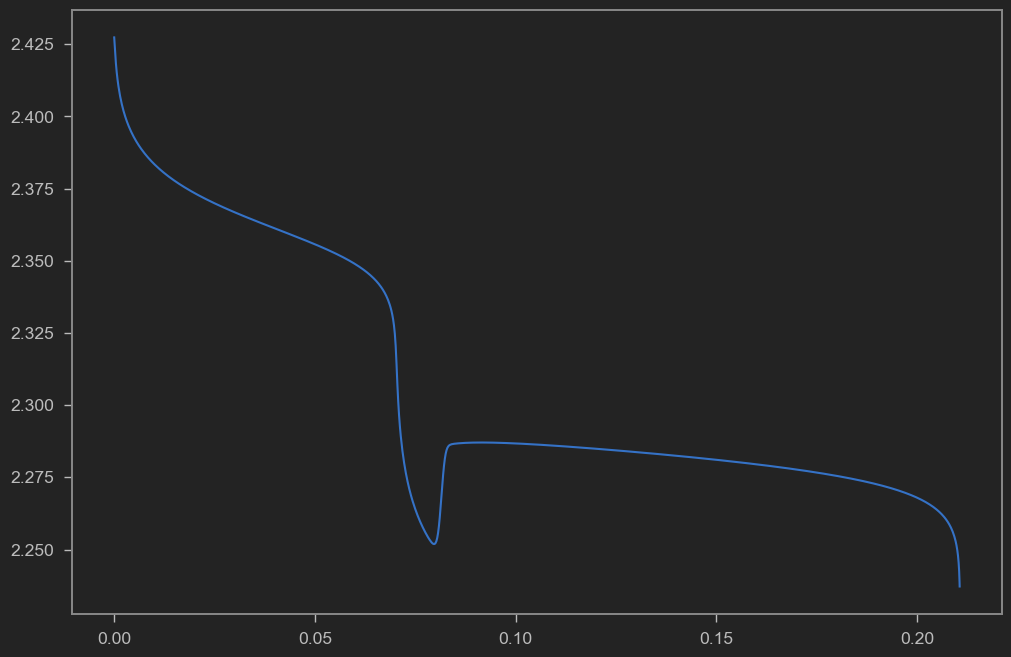

In [411]:
plt.plot(base_sim_data[1],base_sim_data[2])

In [386]:
base_sim.built_model.variables.keys()

dict_keys(['Terminal voltage [V]', 'Current [A]', 'Discharge capacity [A.h]', 'Time [s]', 'S8 [g]', 'S4 [g]', 'S2 [g]', 'S [g]', 'Precipitated Sulfur [g]', 'Cell Temperature [K]', 'Shuttle coefficient [s-1]', 'Shuttle rate [g-1.s-1]', 'High plateau potential [V]', 'Low plateau potential [V]', 'High plateau over-potential [V]', 'Low plateau over-potential [V]', 'High plateau current [A]', 'Low plateau current [A]', 'Theoretical capacity [Ah]', 'Algebraic condition'])

In [396]:
base_sim.built_model.y_slices['Algebraic condition']

KeyError: 'Algebraic condition'

In [341]:
# get simulation data
t, Ah, V, S8, S4, S2, S1, Sp, Tc = base_sim

# get experimental data capacity
exp_capacity = discharge_data['30']['capacity']

# check if simulation stops short of experimental capacity and adjust
if Ah[-1] < exp_capacity[-1]:
    exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]

exp_voltage = discharge_data['30']['internal voltage'][0:len(exp_capacity)]

# down sample simulated voltage for comparison with experimental 
down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)

In [342]:
# create steps for each parameter to fit
individually_stepped_params = []
epsilon = 0.01
for i in range(0,len(fitted_params)):
    step_factor = np.ones(len(fitted_params))
    step_factor[i] = 1+epsilon
    individually_stepped_params.append(fitted_params*step_factor)

In [343]:
# run new simulations with individually stepped parameters
individually_stepped_sims = []
for i in individually_stepped_params:
    inputs = i, temp
    temp_sim = hua_2019_alg_discharge_function_ks(inputs)
    individually_stepped_sims.append(temp_sim)


notify

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.2018 2.35  ]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.18   2.3735]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [344]:
# downsample each sim to be able to subtract from base_sim for numerical derivative
gradient = np.array([])
for sims in individually_stepped_sims:
    # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes
    
    # down sample simulated voltage for comparison with experimental 
    temp_sim_V = np.interp(exp_capacity, sims[1], sims[2])
    voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon 
    gradient = np.append(gradient, sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage))


In [345]:
lam = 0.01
new_params = fitted_params - lam*gradient

In [346]:
fitted_params

array([2.18, 2.35])

In [347]:
new_params

array([2.17292273, 2.34709414])

In [348]:
inputs = new_params, temp
sim2 = hua_2019_alg_discharge_function_ks(inputs)

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.17292273 2.34709414]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

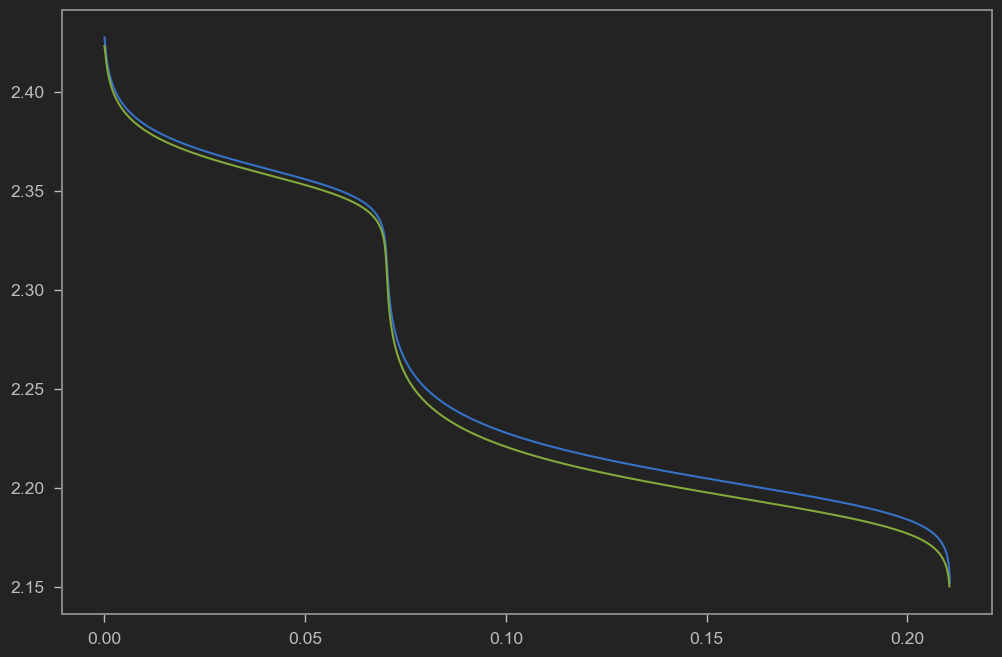

In [350]:
plt.plot(Ah, V)
plt.plot(sim2[1],sim2[2])

In [351]:
def quick_norm(gradient):
    return sum(gradient*gradient)


In [352]:
simulations_at_each_step = [base_sim, sim2]
parameters_at_each_step = [fitted_params, new_params]

while quick_norm(gradient) > 1e-7:

    # get new parameters
    params = parameters_at_each_step[-1]

    #### down sample previous simulation for gradient calculation ###
    # get simulation data
    t, Ah, V, S8, S4, S2, S1, Sp, Tc = simulations_at_each_step[-1]

    # get experimental data capacity
    exp_capacity = discharge_data['30']['capacity']

    # check if simulation stops short of experimental capacity and adjust
    if Ah[-1] < exp_capacity[-1]:
        exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]

    exp_voltage = discharge_data['30']['internal voltage'][0:len(exp_capacity)]

    # down sample simulated voltage for comparison with experimental 
    down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)

    ###########################################################

    # create steps for each parameter to fit
    individually_stepped_params = []
    epsilon = 0.01
    for i in range(0,len(params)):
        step_factor = np.ones(len(params))
        step_factor[i] = 1+epsilon
        individually_stepped_params.append(params*step_factor)

    # run new simulations with individually stepped parameters
    individually_stepped_sims = []
    for i in individually_stepped_params:
        inputs = i, temp
        temp_sim = hua_2019_alg_discharge_function_ks(inputs)
        individually_stepped_sims.append(temp_sim)

    # downsample each sim to be able to subtract from base_sim for numerical derivative
    gradient = np.array([])
    for sims in individually_stepped_sims:
        # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes

        # down sample simulated voltage for comparison with experimental 
        temp_sim_V = np.interp(exp_capacity, sims[1], sims[2])
        voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon 
        gradient = np.append(gradient, sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage))

    lam = 0.01
    new_params = params - lam*gradient
    
    # record new parameters 
    parameters_at_each_step.append(new_params)
    
    # obtain new simulation based on these new parameters
    inputs = new_params, temp
    new_sim = hua_2019_alg_discharge_function_ks(inputs)
    
    # record new simulation
    simulations_at_each_step.append(new_sim)
    print('\n\n\n gradient norm is {} \n\n\n'.format(quick_norm(gradient)))
    
    if len(simulations_at_each_step) > 10:
        break

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.19465195 2.34709414]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.17292273 2.37056508]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.16606464 2.34424011]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.5517883654787769 



Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.18772529 2.34424011]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.16606464 2.36768251]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.15941801 2.34143666]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed





 gradient norm is 0.5203699269324444 



Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.18101219 2.34143666]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.15941801 2.36485103]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.15297555 2.3386828 ]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.4908902473161234 



Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.17450531 2.3386828 ]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.15297555 2.36206963]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.14673034 2.33597757]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.4632098318470719 



Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.16819764 2.33597757]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.14673034 2.35933734]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.14067569 2.33332002]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.4372134731481803 



Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.16208245 2.33332002]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.14067569 2.35665322]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.13531284 2.33064267]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.359284130174033 



Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.15666596 2.33064267]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.13531284 2.35394909]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.13084187 2.32782294]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.2794034748883172 



Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.15215029 2.32782294]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.13084187 2.35110117]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.12679832 2.32485559]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.2515547855272801 



Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.14806631 2.32485559]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.12679832 2.34810415]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are [2.1230761  2.32172048]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c




 gradient norm is 0.2368384415891671 





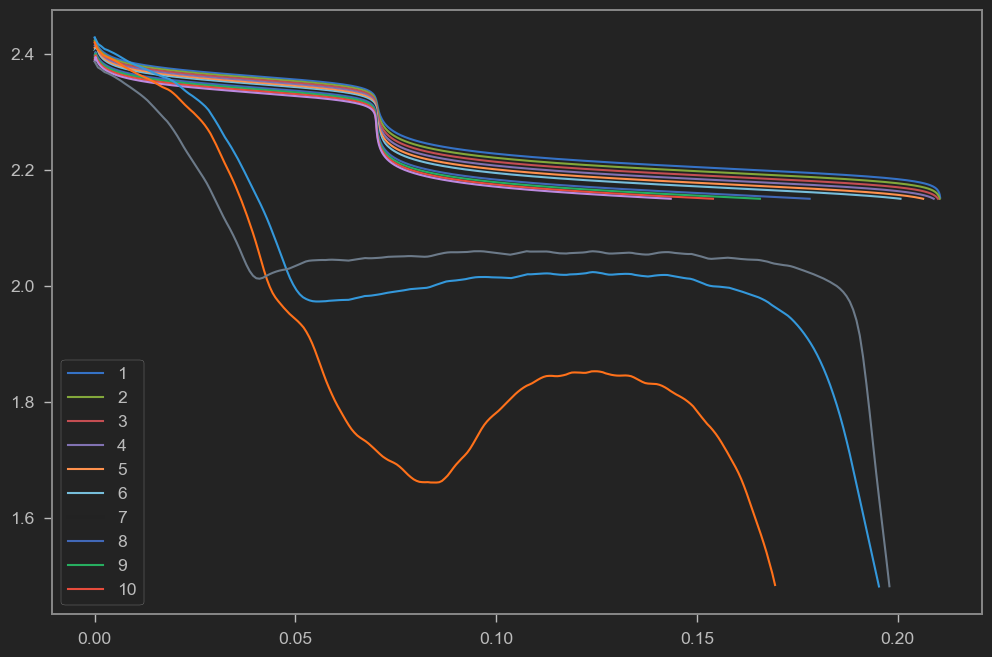

In [353]:
steps = np.arange(1,len(simulations_at_each_step))
for simulations in simulations_at_each_step:
    plt.plot(simulations[1],simulations[2])
plt.legend(steps)
plt.plot(discharge_data['20']['capacity'],discharge_data['20']['internal voltage'])
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'])

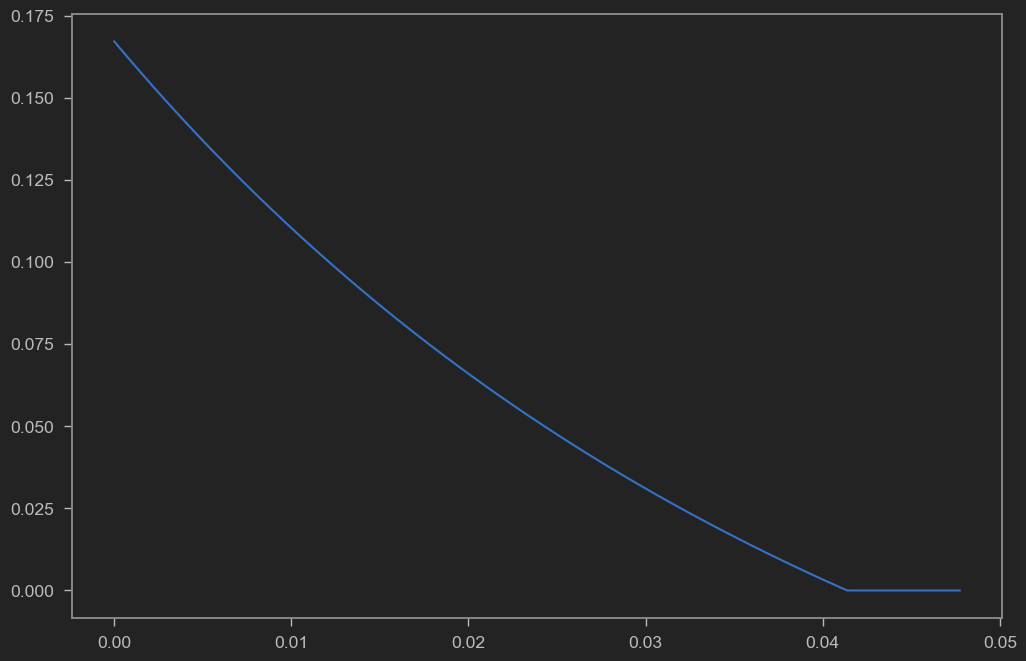

In [225]:
plt.plot(simulations[1],simulations[2])

In [ ]:
# There are several concerning things here.
# One is the disparity between the minimum voltages.
# To be able see if these models can get low voltages, 
# we can try to simply find a state vector, holding V 
# at some low value, and keep I at the discharge value
# in order to find if an internal state (with possibly
# different parameters) can possibly be consistent
# with that low voltage. 


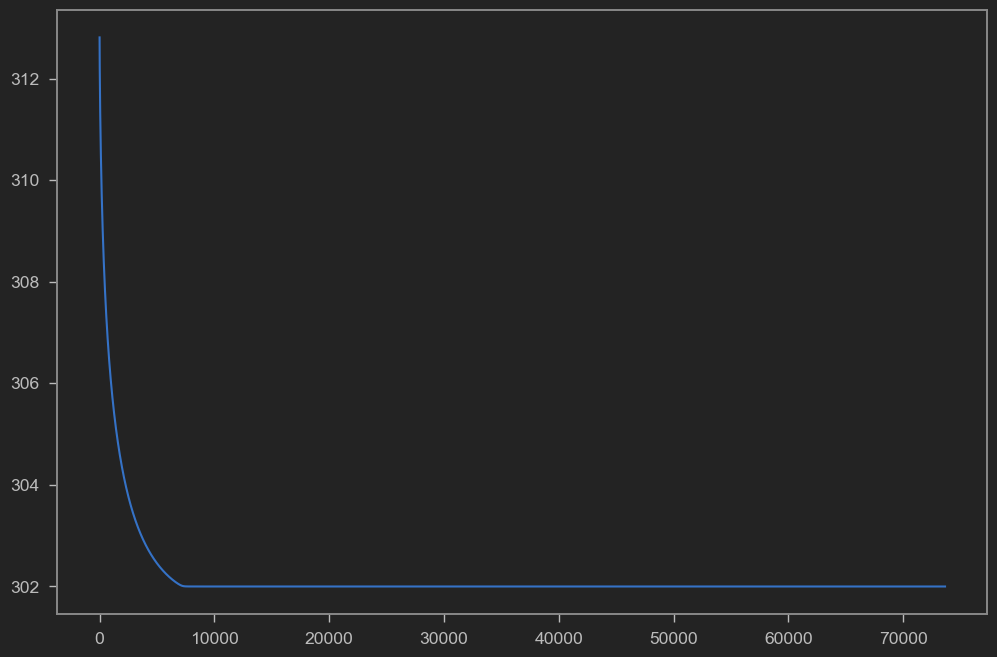

In [23]:
plt.plot(simulations[-1])

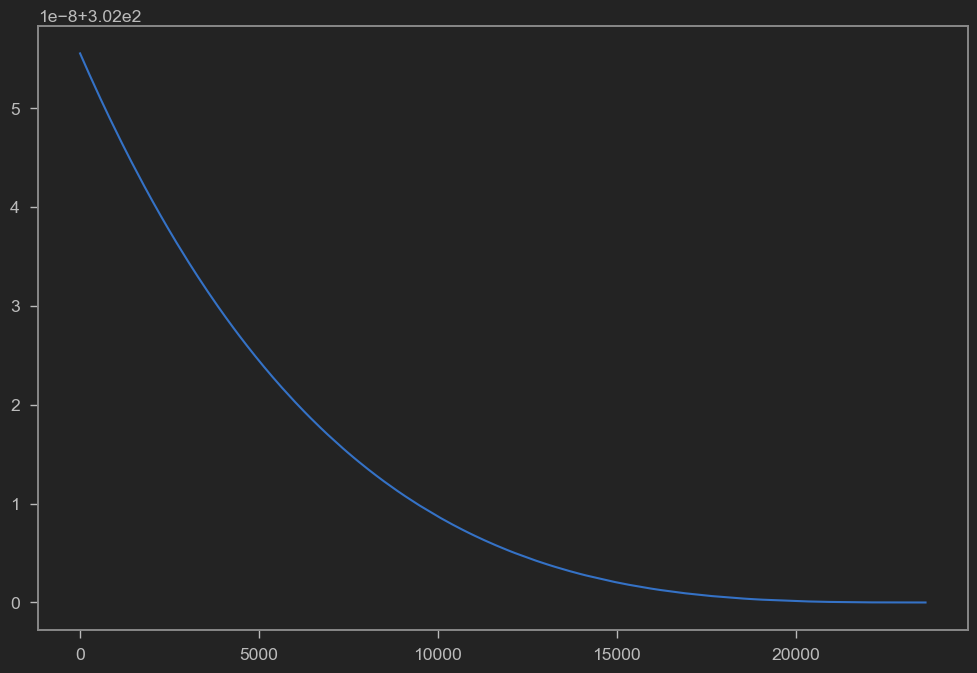

In [26]:
plt.plot(simulations[-1][50000:])

In [33]:
ks0 = 0.0002
A = 8.9712e-20
R = 8.3145
NA = 6.0221e23
T0 = 298

def k_s(T):
    return ks0*np.exp( A*NA*( (1/T) - (1/T0) )/R )

n4 = 4
F = 9.649e4
ns8 = 8
MS = 32
V = 1.8
h = 0.2
Ta = 302

def alg(inputs):
    T = inputs[0]
    S8 = inputs[1]
    return (( k_s(T)*n4*F*S8*V/(ns8*MS) ) - h*(T-Ta))**2

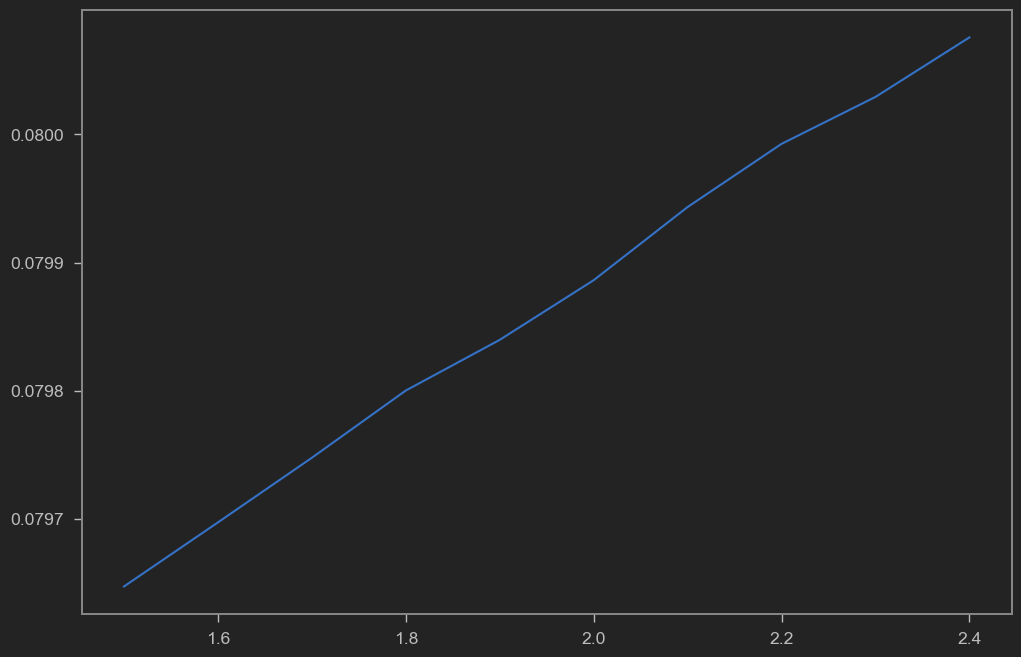

In [53]:
import scipy as sp
bounds = sp.optimize.Bounds(np.array([0,1e-20]),np.array([np.inf, .168]))
S8_array = []
temp_array = []
voltage_space = np.linspace(1.5,2.4,10)
for voltages in voltage_space:
    V = voltages
    
    ks0 = 0.0002
    A = 8.9712e-20
    R = 8.3145
    NA = 6.0221e23
    T0 = 298

    def k_s(T):
        return ks0*np.exp( A*NA*( (1/T) - (1/T0) )/R )

    n4 = 4
    F = 9.649e4
    ns8 = 8
    MS = 32
    #V = 1.8
    h = 0.2
    Ta = 302

    def alg(inputs):
        T = inputs[0]
        S8 = inputs[1]
        return (( k_s(T)*n4*F*S8*V/(ns8*MS) ) - h*(T-Ta))**2
    
    values = sp.optimize.minimize(alg, np.array([320,.168]),bounds=bounds)
    S8_array.append(values.x[1])
    temp_array.append(values.x[0])
    
plt.plot(voltage_space, S8_array)

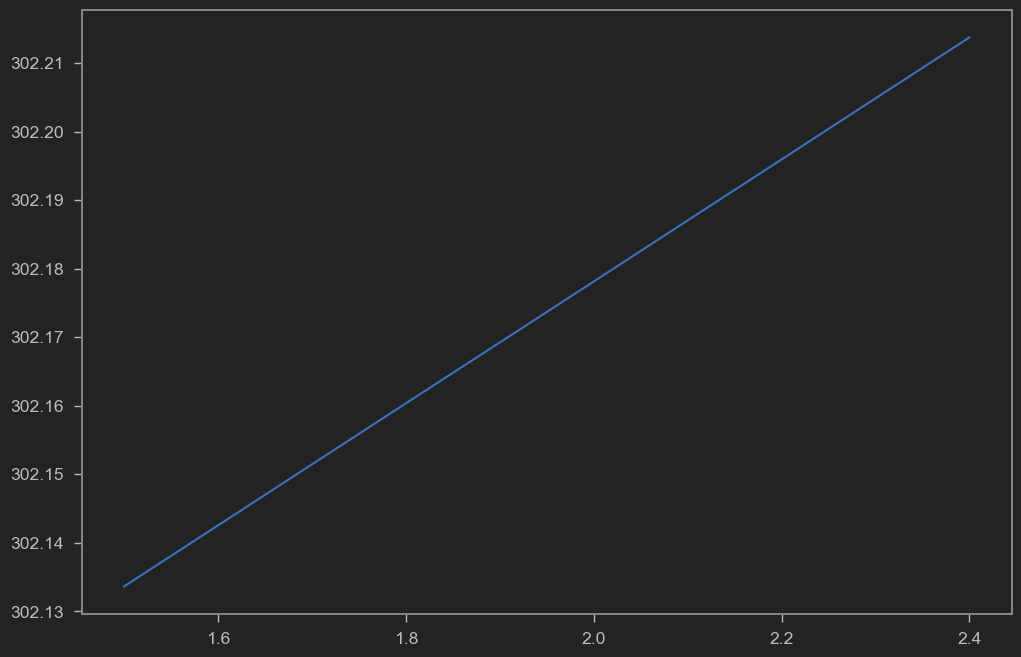

In [54]:
plt.plot(voltage_space, temp_array)

In [68]:
def voltage_S8_relation(initial_temp, initial_S8, Ta):
    bounds = sp.optimize.Bounds(np.array([0,1e-20]),np.array([np.inf, .168]))
    S8_array = []
    temp_array = []
    voltage_space = np.linspace(1.5,2.4,10)
    for voltages in voltage_space:
        V = voltages

        ks0 = 0.0002
        A = 8.9712e-20
        R = 8.3145
        NA = 6.0221e23
        T0 = 298

        def k_s(T):
            return ks0*np.exp( A*NA*( (1/T) - (1/T0) )/R )

        n4 = 4
        F = 9.649e4
        ns8 = 8
        MS = 32
        #V = 1.8
        h = 0.2
        #Ta = 302

        def alg(inputs):
            T = inputs[0]
            S8 = inputs[1]
            return (( k_s(T)*n4*F*S8*V/(ns8*MS) ) - h*(T-Ta))**2

        values = sp.optimize.minimize(alg, np.array([320,.168]),bounds=bounds)
        S8_array.append(values.x[1])
        temp_array.append(values.x[0])
    return temp_array, S8_array

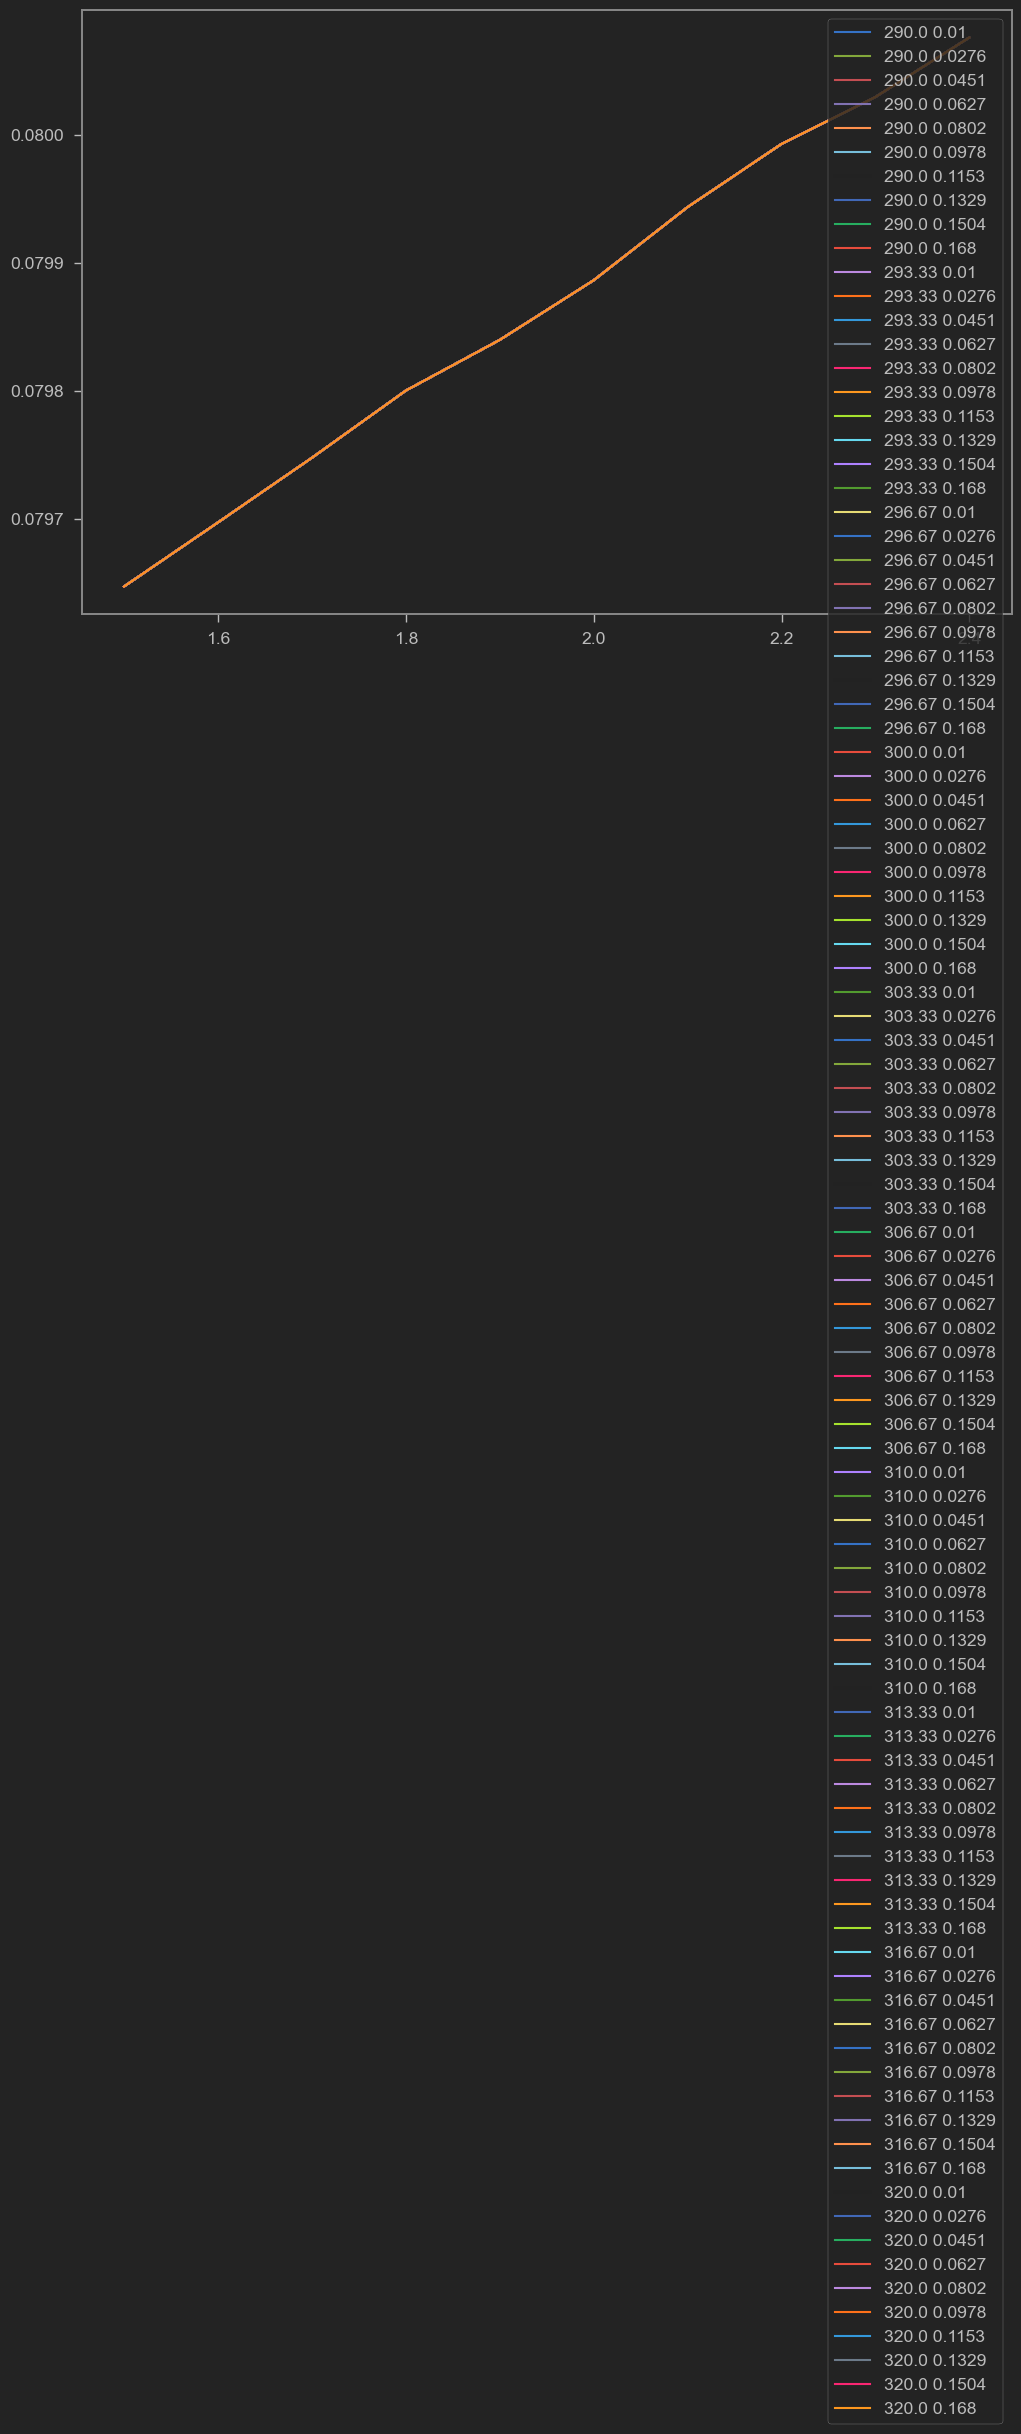

In [72]:
initial_temp_guesses = np.linspace(290,320,10)
initial_S8_guesses = np.linspace(0.01,.168,10)
voltage_space = np.linspace(1.5,2.4,10)
legend = []

for initial_temp in initial_temp_guesses:
    for initial_S8 in initial_S8_guesses:
        temp_array, S8_array = voltage_S8_relation(initial_temp, initial_S8, 302)
        legend.append( str(round(initial_temp,2)) + ' ' + str(round(initial_S8,4)))
        plt.plot(voltage_space, S8_array)
        
plt.legend(legend,loc = 'upper right')

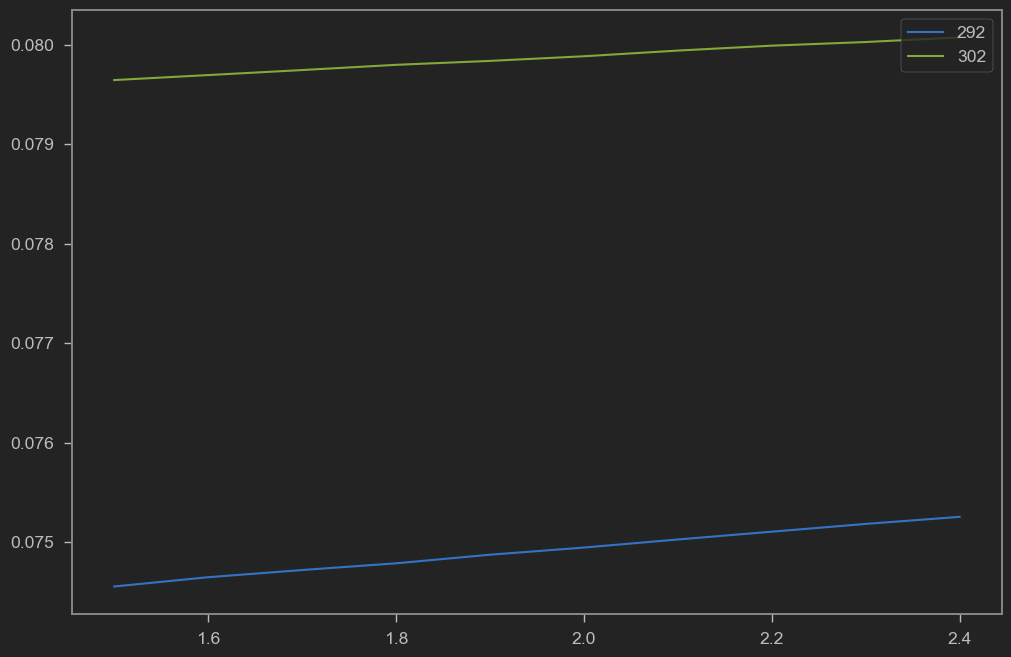

In [74]:
initial_temp_guesses = np.linspace(290,320,10)
initial_S8_guesses = np.linspace(0.01,.168,10)
voltage_space = np.linspace(1.5,2.4,10)
legend = []

initial_temp = initial_temp_guesses[-1]
initial_S8 = initial_S8_guesses[-1]

for Ta in [292,302]:
        temp_array, S8_array = voltage_S8_relation(initial_temp, initial_S8, Ta)
        legend.append( str(Ta))
        plt.plot(voltage_space, S8_array)

plt.legend(legend,loc = 'upper right')

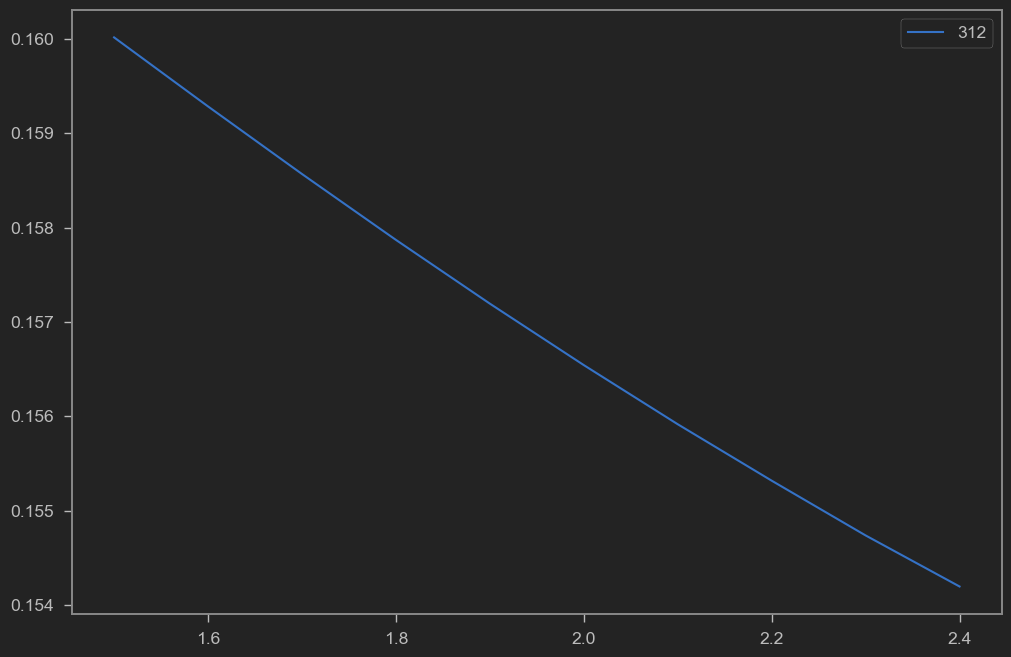

In [75]:
initial_temp_guesses = np.linspace(290,320,10)
initial_S8_guesses = np.linspace(0.01,.168,10)
voltage_space = np.linspace(1.5,2.4,10)
legend = []

initial_temp = initial_temp_guesses[-1]
initial_S8 = initial_S8_guesses[-1]

for Ta in [312]:
        temp_array, S8_array = voltage_S8_relation(initial_temp, initial_S8, Ta)
        legend.append( str(Ta))
        plt.plot(voltage_space, S8_array)

plt.legend(legend,loc = 'upper right')

In [76]:
initial_data

[2.4,
 0.1671988053302967,
 0.0008006527153863815,
 2.7097715846291745e-07,
 1.020894763111026e-07,
 1.6888768215181486e-07]

In [463]:
# The fitting might work better for the charge curves since they are more similar. 

# first we need to get an IC for the charge. Then we will run through essentially the same 
# functions for discharge and see if the fitting provides some positive changes. 

# we have the data in base_sim

charge_initial_data = []
for sub_data in base_sim_data[2:-1]:
    charge_initial_data.append(sub_data[-2])
    
print(charge_initial_data)

# set inititial guessed for the parameters we will fit
active_surface_area = 0.960
discharge_shuttle_rate = 0.00#02
saturation_mass = 0.01
precipitation_rate = 1000
heat_transfer_coefficient = .2

EH0 = 2.4
EL0 = 2.15

fitted_params = np.array([EL0, EH0])

[2.2377481633144485, 7.354380552875399e-16, 0.00012908610799497604, 0.08393545694600031, 0.00011904037988887775, 0.08381641656611105]


In [464]:
def hua_2019_alg_charge_function(inputs):
    
    fitted_params, temp = inputs
    
    current = -0.0211 # .1C charge
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    EL0, EH0 = fitted_params
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = charge_initial_data
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 0.00002,
        "Shuttle rate coefficient during discharge [s-1]": discharge_shuttle_rate,
        'S saturation mass [g]': saturation_mass,
        'Precipitation rate [s-1]': precipitation_rate,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": 298,
        'Active reaction area per cell [m2]': active_surface_area,
        'Cell heat transfer coefficient [W.K-1]': heat_transfer_coefficient,
        'Standard Potential L [V]': EL0,
        'Standard Potential H [V]': EH0 
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying time %f" %10**j)
        print("parameters are {}".format(fitted_params))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = [t, Ah, V, S8, S4, S2, S1, Sp, Tc]
            return data
            
            break
        except:
            pass


In [ ]:
base_charge_sim = hua_2019_alg_charge_function(inputs)

Starting temperature 302.000000
trying time 1000.000000
parameters are [2.18 2.35]
trying time 10000.000000
parameters are [2.18 2.35]
trying time 100000.000000
parameters are [2.18 2.35]
trying time 1000000.000000
parameters are [2.18 2.35]


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [ ]:
plt.plot(base_charge_sim[1],base_charge_sim[2])

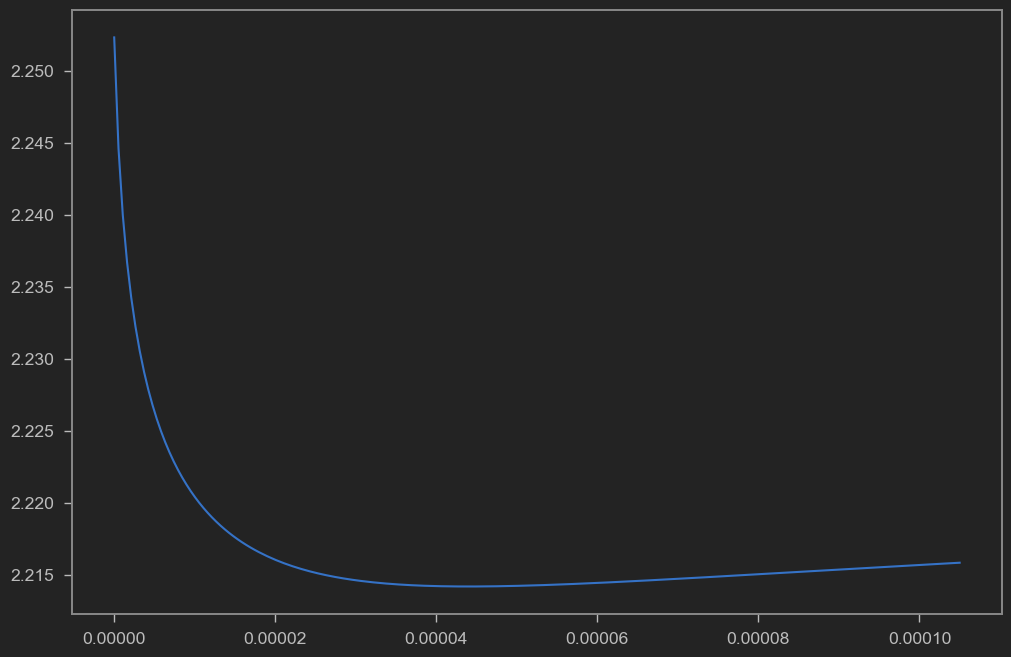

In [99]:
end_val = 200
plt.plot(base_charge_sim[1][:end_val],base_charge_sim[2][:end_val])

In [100]:
charge_initial_data = []
for sub_data in base_charge_sim[2:-1]:
    charge_initial_data.append(sub_data[200])
    
charge_initial_data

[2.2158555258106603,
 9.164522220279942e-17,
 0.0002453608337872836,
 0.08387731958310841,
 0.002815142627468991,
 0.08106217695564115]

Starting temperature 302.000000
trying time 36000.000000
parameters are [9.59987417e-01 1.25357480e-03 2.82638615e-03 1.09999601e+02]


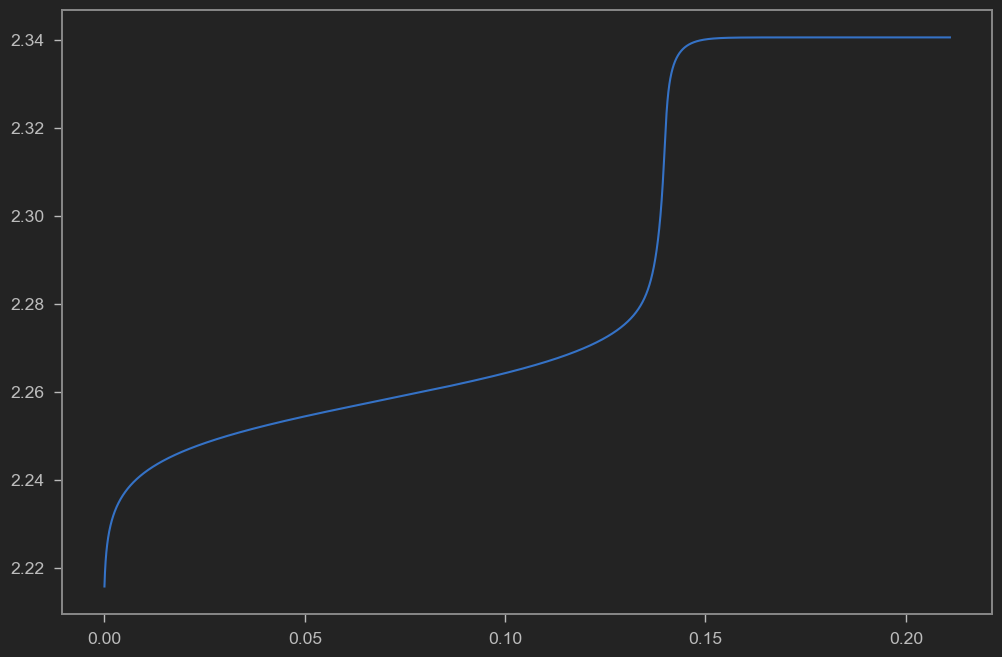

In [101]:
base_charge_sim2 = hua_2019_alg_charge_function(inputs)
plt.plot(base_charge_sim2[1],base_charge_sim2[2])

In [104]:
# get simulation data
t, Ah, V, S8, S4, S2, S1, Sp, Tc = base_charge_sim2

# get experimental data capacity
exp_capacity = charge_data['30']['capacity']

# check if simulation stops short of experimental capacity and adjust
if Ah[-1] < exp_capacity[-1]:
    exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]

exp_voltage = charge_data['30']['internal voltage'][0:len(exp_capacity)]

# down sample simulated voltage for comparison with experimental 
down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)

In [106]:
# create steps for each parameter to fit
individually_stepped_params = []
epsilon = 0.1
for i in range(0,len(fitted_params)):
    step_factor = np.ones(len(fitted_params))
    step_factor[i] = 1+epsilon
    individually_stepped_params.append(fitted_params*step_factor)

In [108]:
# run new simulations with individually stepped parameters
individually_stepped_sims = []
for i in individually_stepped_params:
    inputs = i, temp
    temp_sim = hua_2019_alg_charge_function(inputs)
    individually_stepped_sims.append(temp_sim)


notify

Starting temperature 302.000000
trying time 36000.000000
parameters are [1.056e+00 2.000e-05 1.000e-04 1.000e+02]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.6e-01 2.2e-05 1.0e-04 1.0e+02]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.6e-01 2.0e-05 1.1e-04 1.0e+02]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.6e-01 2.0e-05 1.0e-04 1.1e+02]


In [109]:
# downsample each sim to be able to subtract from base_sim for numerical derivative
gradient = np.array([])
for sims in individually_stepped_sims:
    # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes
    
    # down sample simulated voltage for comparison with experimental 
    temp_sim_V = np.interp(exp_capacity, sims[1], sims[2])
    voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon 
    gradient = np.append(gradient, sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage))


In [125]:
lam = 0.1
# we are using lam adjusted for each component of the gradient to avoid negative parameter values
new_params = fitted_params - lam*fitted_params*gradient

In [126]:
new_params

array([9.57783960e-01, 1.99536151e-05, 9.97791831e-05, 9.97716901e+01])

In [127]:
inputs = new_params, temp
charge_sim2 = hua_2019_alg_charge_function(inputs)

Starting temperature 302.000000
trying time 36000.000000
parameters are [9.57783960e-01 1.99536151e-05 9.97791831e-05 9.97716901e+01]


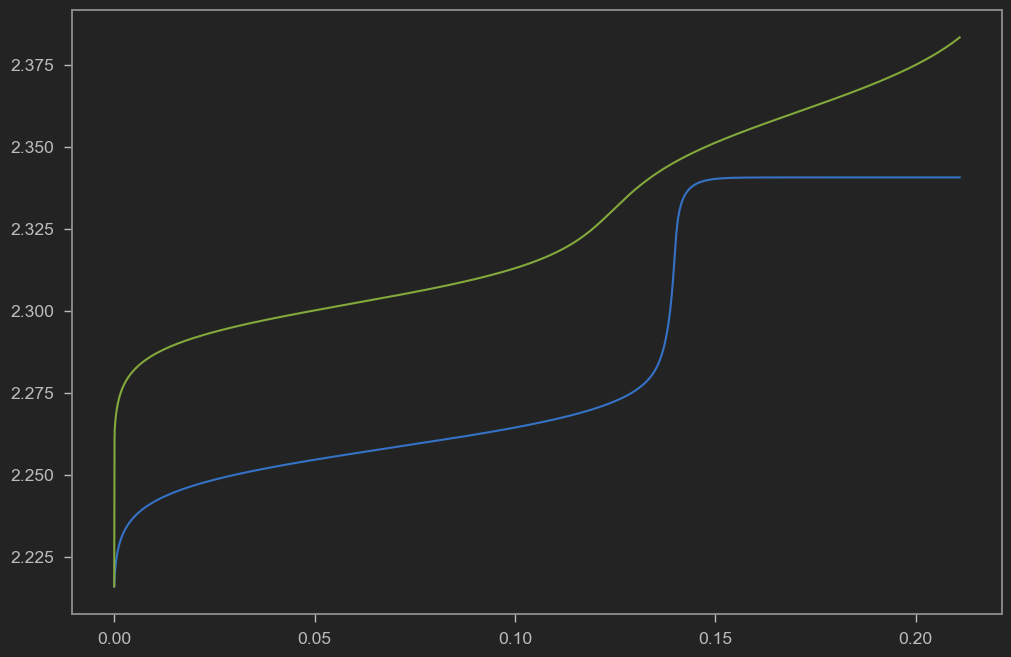

In [128]:
plt.plot(Ah, V)
plt.plot(charge_sim2[1],charge_sim2[2])

In [139]:
simulations_at_each_step = [base_charge_sim2, charge_sim2]
parameters_at_each_step = [fitted_params, new_params]
gradient = np.array([1,1])
while quick_norm(gradient) > 1e-7:

    # get new parameters
    params = parameters_at_each_step[-1]

    #### down sample previous simulation for gradient calculation ###
    # get simulation data
    t, Ah, V, S8, S4, S2, S1, Sp, Tc = simulations_at_each_step[-1]

    # get experimental data capacity
    exp_capacity = charge_data['30']['capacity']

    # check if simulation stops short of experimental capacity and adjust
    if Ah[-1] < exp_capacity[-1]:
        exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]

    exp_voltage = charge_data['30']['internal voltage'][0:len(exp_capacity)]

    # down sample simulated voltage for comparison with experimental 
    down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)

    ###########################################################

    # create steps for each parameter to fit
    individually_stepped_params = []
    epsilon = 0.1
    for i in range(0,len(params)):
        step_factor = np.ones(len(params))
        step_factor[i] = 1+epsilon
        individually_stepped_params.append(params*step_factor)

    # run new simulations with individually stepped parameters
    individually_stepped_sims = []
    for i in individually_stepped_params:
        inputs = i, temp
        temp_sim = hua_2019_alg_charge_function(inputs)
        individually_stepped_sims.append(temp_sim)

    # downsample each sim to be able to subtract from base_sim for numerical derivative
    gradient = np.array([])
    for sims in individually_stepped_sims:
        # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes

        # down sample simulated voltage for comparison with experimental 
        temp_sim_V = np.interp(exp_capacity, sims[1], sims[2])
        voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon 
        gradient = np.append(gradient, sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage))

    lam = 0.1
    new_params = params - lam*gradient
    
    # record new parameters 
    parameters_at_each_step.append(new_params)
    
    # obtain new simulation based on these new parameters
    inputs = new_params, temp
    new_sim = hua_2019_alg_charge_function(inputs)
    
    # record new simulation
    simulations_at_each_step.append(new_sim)
    print('\n\n\n gradient norm is {} \n\n\n'.format(quick_norm(gradient)))
    
    if len(simulations_at_each_step) > 10:
        break

Starting temperature 302.000000
trying time 36000.000000
parameters are [1.05356404e+00 1.99530818e-05 9.98824567e-05 9.98015438e+01]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.57785488e-01 2.19483900e-05 9.98824567e-05 9.98015438e+01]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.57785488e-01 1.99530818e-05 1.09870702e-04 9.98015438e+01]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.57785488e-01 1.99530818e-05 9.98824567e-05 1.09781698e+02]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.57788271e-01 1.70713866e-05 3.09250911e-04 9.98016061e+01]



 gradient norm is 4.772831772923322e-06 



Starting temperature 302.000000
trying time 36000.000000
parameters are [1.05356710e+00 1.70713866e-05 3.09250911e-04 9.98016061e+01]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.57788271e-01 1.87785253e-05 3.09250911e-04 9.98016061e+01]
Starting temper

res failed: KeyboardInterrupt
At t = 1392.24, the residual function failed unrecoverably.


trying time 35800.000000
parameters are [1.05356823e+00 2.85149735e-06 8.16590130e-04 9.98016518e+01]
trying time 35700.000000
parameters are [1.05356823e+00 2.85149735e-06 8.16590130e-04 9.98016518e+01]


psetup failed: KeyboardInterrupt


Starting temperature 302.000000
trying time 36000.000000
parameters are [9.57789296e-01 3.13664708e-06 8.16590130e-04 9.98016518e+01]
trying time 35900.000000
parameters are [9.57789296e-01 3.13664708e-06 8.16590130e-04 9.98016518e+01]
trying time 35800.000000
parameters are [9.57789296e-01 3.13664708e-06 8.16590130e-04 9.98016518e+01]
trying time 35700.000000
parameters are [9.57789296e-01 3.13664708e-06 8.16590130e-04 9.98016518e+01]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.57789296e-01 2.85149735e-06 8.98249143e-04 9.98016518e+01]


res failed: KeyboardInterrupt
At t = 850.694, the residual function failed unrecoverably.
res failed: KeyboardInterrupt
At t = 1169.65, the residual function failed unrecoverably.
psetup failed: KeyboardInterrupt


trying time 35900.000000
parameters are [9.57789296e-01 2.85149735e-06 8.98249143e-04 9.98016518e+01]


res failed: KeyboardInterrupt
At t = 654.106, the residual function failed unrecoverably.


trying time 35800.000000
parameters are [9.57789296e-01 2.85149735e-06 8.98249143e-04 9.98016518e+01]
trying time 35700.000000
parameters are [9.57789296e-01 2.85149735e-06 8.98249143e-04 9.98016518e+01]
Starting temperature 302.000000
trying time 36000.000000
parameters are [9.57789296e-01 2.85149735e-06 8.16590130e-04 1.09781817e+02]
trying time 35900.000000
parameters are [9.57789296e-01 2.85149735e-06 8.16590130e-04 1.09781817e+02]
trying time 35800.000000
parameters are [9.57789296e-01 2.85149735e-06 8.16590130e-04 1.09781817e+02]
trying time 35700.000000
parameters are [9.57789296e-01 2.85149735e-06 8.16590130e-04 1.09781817e+02]


TypeError: 'NoneType' object is not subscriptable

Text(0, 0.5, 'Voltage [V]')

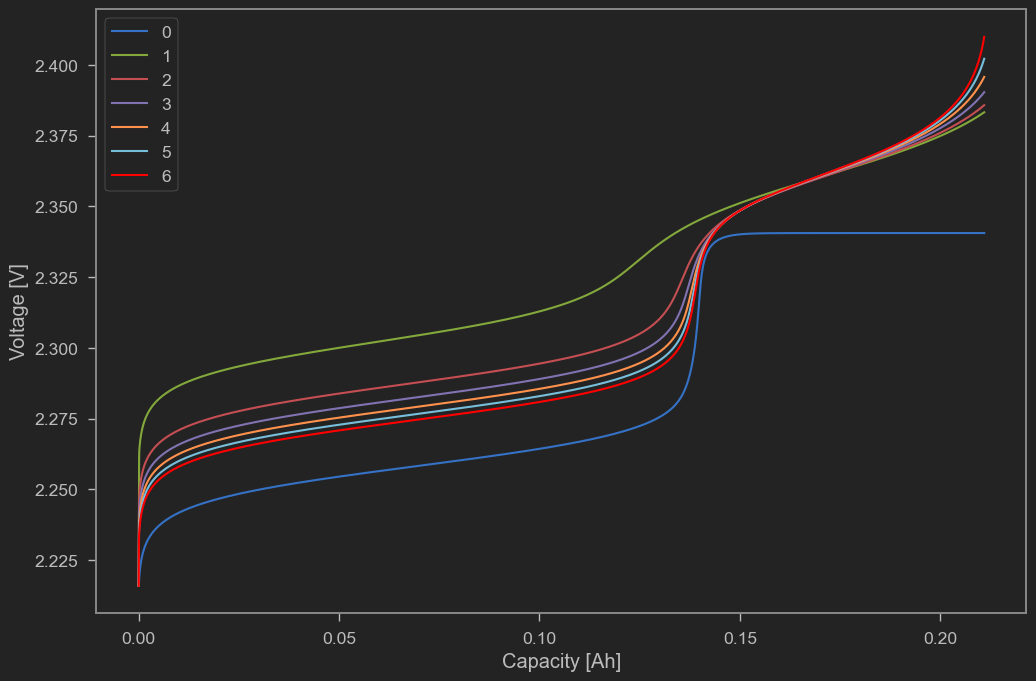

In [144]:
for simulations in simulations_at_each_step[:-1]:
    plt.plot(simulations[1],simulations[2])
plt.plot(simulations_at_each_step[-1][1],simulations_at_each_step[-1][2],color='red')
plt.legend(np.arange(len(simulations_at_each_step)))
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
#plt.ylim(2,2.5)

(1.5, 2.5)

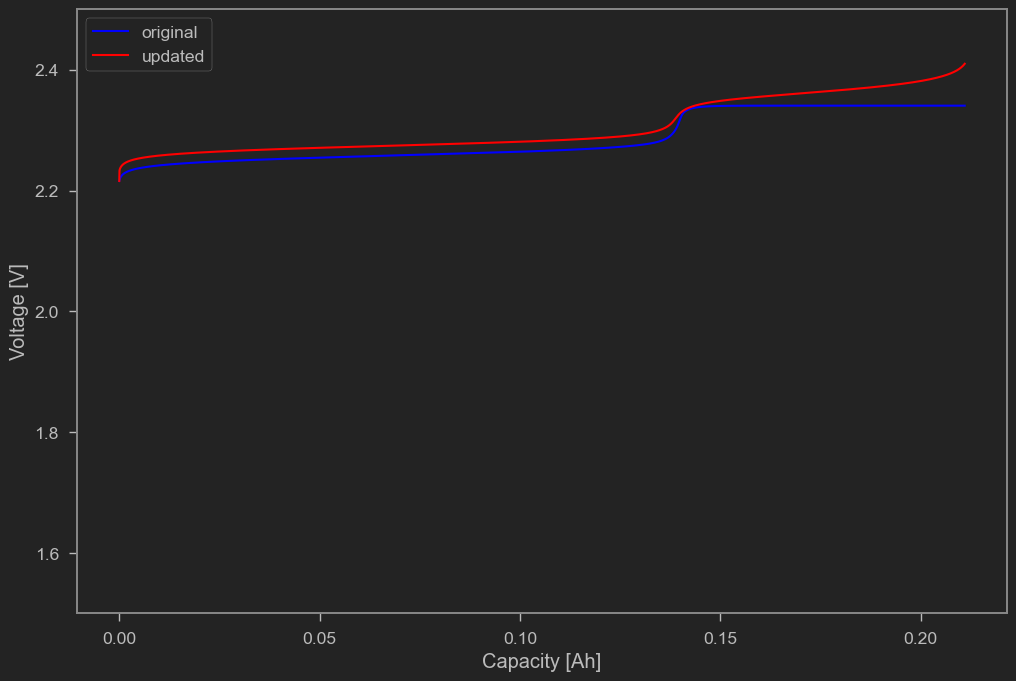

In [147]:
plt.plot(simulations_at_each_step[0][1],simulations_at_each_step[0][2],color='blue')
plt.plot(simulations_at_each_step[-1][1],simulations_at_each_step[-1][2],color='red')
plt.legend(['original', 'updated'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.ylim(1.5,2.5)

In [103]:
simulations_at_each_step = [base_charge_sim2]
parameters_at_each_step = [fitted_params]
gradient = 1e-6
while quick_norm(gradient) > 1e-7:

    # get new parameters
    params = parameters_at_each_step[-1]

    #### down sample previous simulation for gradient calculation ###
    # get simulation data
    t, Ah, V, S8, S4, S2, S1, Sp, Tc = simulations_at_each_step[-1]

    # get experimental data capacity
    exp_capacity = charge_data['30']['capacity']

    # check if simulation stops short of experimental capacity and adjust
    if Ah[-1] < exp_capacity[-1]:
        exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]

    exp_voltage = charge_data['30']['internal voltage'][0:len(exp_capacity)]

    # down sample simulated voltage for comparison with experimental 
    down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)

    ###########################################################

    # create steps for each parameter to fit
    individually_stepped_params = []
    epsilon = 0.1
    for i in range(0,len(params)):
        step_factor = np.ones(len(params))
        step_factor[i] = 1+epsilon
        individually_stepped_params.append(params*step_factor)

    # run new simulations with individually stepped parameters
    individually_stepped_sims = []
    for i in individually_stepped_params:
        inputs = i, temp
        temp_sim = hua_2019_alg_charge_function(inputs)
        individually_stepped_sims.append(temp_sim)

    # downsample each sim to be able to subtract from base_sim for numerical derivative
    gradient = np.array([])
    for sims in individually_stepped_sims:
        # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes

        # down sample simulated voltage for comparison with experimental 
        temp_sim_V = np.interp(exp_capacity, sims[1], sims[2])
        voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon 
        gradient = np.append(gradient, sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage))

    lam = 0.1
    new_params = params - lam*gradient
    
    # record new parameters 
    parameters_at_each_step.append(new_params)
    
    # obtain new simulation based on these new parameters
    inputs = new_params, temp
    new_sim = hua_2019_alg_charge_function(inputs)
    
    # record new simulation
    simulations_at_each_step.append(new_sim)
    print('\n\n\n gradient norm is {} \n\n\n'.format(quick_norm(gradient)))
    
    if len(simulations_at_each_step) > 10:
        break

TypeError: 'float' object is not iterable